### Install Required Packages

We would be running `Stable Diffusion 2` so enable `GPU` under `View Resources > Change runtime type`

In [3]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-2b43e1e3-bc17-5245-185a-41a2e460bf21)


In [4]:
!git clone https://github.com/RishiDarkDevil/daam.git

fatal: destination path 'daam' already exists and is not an empty directory.


In [5]:
cd daam

/content/daam


In [6]:
!pip install .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/daam
  Preparing metadata (setup.py) ... done
  Created wheel for daam: filename=daam-0.0.12-py3-none-any.whl size=22841 sha256=b8d79eb0644978305acc9faaa42634317a8cebf89ed943ff5d270820aefc36c8
  Stored in directory: /tmp/pip-ephem-wheel-cache-0hajui67/wheels/25/21/32/f0ffca34a947dfb898b1109d195aa871c3137bde4fdd3ab1cd
Successfully built daam
  Attempting uninstall: daam
    Found existing installation: daam 0.0.12
    Uninstalling daam-0.0.12:
      Successfully uninstalled daam-0.0.12


In [7]:
# import daam

In [8]:
# daam.trace

### Import Necessary Libraries

We will load the necessary libraries required for generating DAAM outputs for input prompts.

In [9]:
# General
import os
import json
import datetime
from tqdm import tqdm
import base64
import IPython
import random

# Plotting
from matplotlib import pyplot as plt

# Data Handling
import numpy as np

# Image Processing
from PIL import Image
from PIL import ImageDraw as PILImageDraw
import cv2


# Image Generation
from diffusers import StableDiffusionPipeline
import daam

# Model
import torch

### Load Model

In [10]:
# prompts = [
#   "A group of people stand in the back of trucks filled with cotton.",
#   "A mother and three children collecting garbage from a blue and white garbage can on the street.",
#   "A woman is sitting in a chair reading a book with her head resting on her free hand.",
#   "A brown and white dog exiting a yellow and blue ramp in a grassy area.",
#   "A boy stands on a rocky mountain."
#   ]

# prompts = [
#   "\"\"\"<p><a class=\"\"\"\"link rapid-noclick-resp\"\"\"\" href=\"\"\"\"https://go.redirectingat.com?id=127X1599956&url=https%3A%2F%2Fwww.awaytravel.com%2Fuk%2Fen%2Fsuitcases%2Fcarry-on%2Fblack&sref=https%3A%2F%2Fwww.harpersbazaar.com%2Fuk%2Ffashion%2Fg28897412%2Fwork-bags-women%2F\"\"\"\" rel=\"\"\"\"nofollow noopener\"\"\"\" target=\"\"\"\"_blank\"\"\"\" data-ylk=\"\"\"\"slk:SHOP NOW\"\"\"\">SHOP NOW</a></p><p>Business trips might be strictly Skype-based at the moment, but there will come a time when travelling for work is the norm again. Do it with ease, ditching the handbag and weekender combo for Away's sleek carry-on suitcase. The effortless four wheel glide is a blessing when you're rushing from meeting to meeting, plus there's an inbuilt battery for charging your phone on the go.</p><p>The Carry-On, \u00a3225, <a href=\"\"\"\"https://go.redirectingat.com?id=127X1599956&url=https%3A%2F%2Fwww.awaytravel.com%2Fuk%2Fen%2Fsuitcases%2Fcarry-on%2Fblack&sref=https%3A%2F%2Fwww.harpersbazaar.com%2Fuk%2Ffashion%2Fg28897412%2Fwork-bags-women%2F\"\"\"\" rel=\"\"\"\"nofollow noopener\"\"\"\" target=\"\"\"\"_blank\"\"\"\" data-ylk=\"\"\"\"slk:Away\"\"\"\" class=\"\"\"\"link rapid-noclick-resp\"\"\"\">Away</a></p>\"\"\"",
#   "World of Speed. \u0422\u0440\u0435\u0439\u043b\u0435\u0440",
#   "Street - In the car ! (Fran\u00e7ois Escriva) Tags: street streetphotography paris france candid olympus omd brothers fun funny boys children delivery cargo bike bicycle little bw black white monochrome noir blanc nb wheel look",
#   "\u0432\u0441\u0435 \u0446\u0435\u043d\u044b \u043d\u0430 For BMW X5 E53 2004 2005 2006 Excellent Ultra bright Dual Color Switchback smd LED Angel Eyes kit",
# ]

prompt = ["World of Speed. \u0422\u0440\u0435\u0439\u043b\u0435\u0440"]*2

In [11]:
DEVICE = 'cuda' # device

Now, let's load the `stabilityai/stable-diffusion-2-base` diffusion model.

In [12]:
model = StableDiffusionPipeline.from_pretrained('stabilityai/stable-diffusion-2-base')
model = model.to(DEVICE) # Set it to something else if needed, make sure DAAM supports that

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

### DAAM Image Attention

In [13]:
from functools import lru_cache
from pathlib import Path
import os
import sys
import random
from typing import TypeVar

import PIL.Image
import matplotlib.pyplot as plt
import numpy as np
import spacy
import torch
import torch.nn.functional as F


__all__ = ['set_seed', 'compute_token_merge_indices', 'plot_mask_heat_map', 'cached_nlp', 'cache_dir', 'auto_device', 'auto_autocast']


T = TypeVar('T')


def auto_device(obj: T = torch.device('cpu')) -> T:
    if isinstance(obj, torch.device):
        return torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    if torch.cuda.is_available():
        return obj.to('cuda')

    return obj


def auto_autocast(*args, **kwargs):
    if not torch.cuda.is_available():
        kwargs['enabled'] = False

    return torch.cuda.amp.autocast(*args, **kwargs)


def plot_mask_heat_map(im: PIL.Image.Image, heat_map: torch.Tensor, threshold: float = 0.4):
    im = torch.from_numpy(np.array(im)).float() / 255
    mask = (heat_map.squeeze() > threshold).float()
    im = im * mask.unsqueeze(-1)
    plt.imshow(im)


def set_seed(seed: int) -> torch.Generator:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    gen = torch.Generator(device=auto_device())
    gen.manual_seed(seed)

    return gen


def cache_dir() -> Path:
    # *nix
    if os.name == 'posix' and sys.platform != 'darwin':
        xdg = os.environ.get('XDG_CACHE_HOME', os.path.expanduser('~/.cache'))
        return Path(xdg, 'daam')
    elif sys.platform == 'darwin':
        # Mac OS
        return Path(os.path.expanduser('~'), 'Library/Caches/daam')
    else:
        # Windows
        local = os.environ.get('LOCALAPPDATA', None) \
                or os.path.expanduser('~\\AppData\\Local')
        return Path(local, 'daam')


def compute_token_merge_indices(tokenizer, prompt: str, word: str, word_idx: int = None, offset_idx: int = 0):
    merge_idxs = []
    tokens = tokenizer.tokenize(prompt.lower())
    if word_idx is None:
        word = word.lower()
        search_tokens = tokenizer.tokenize(word)
        start_indices = [x + offset_idx for x in range(len(tokens)) if tokens[x:x + len(search_tokens)] == search_tokens]
        for indice in start_indices:
            merge_idxs += [i + indice for i in range(0, len(search_tokens))]
        if not merge_idxs:
            raise Exception(f'Search word {word} not found in prompt!')
    else:
        merge_idxs.append(word_idx)

    return [x + 1 for x in merge_idxs], word_idx  # Offset by 1.


nlp = None


@lru_cache(maxsize=100000)
def cached_nlp(prompt: str, type='en_core_web_md'):
    global nlp

    if nlp is None:
        try:
            nlp = spacy.load(type)
        except OSError:
            import os
            os.system(f'python -m spacy download {type}')
            nlp = spacy.load(type)

    return nlp(prompt)

In [14]:
from collections import defaultdict
from typing import List, Union

from scipy.optimize import linear_sum_assignment
import PIL.Image as Image
import numpy as np
import torch
import torch.nn.functional as F


__all__ = ['compute_iou', 'MeanEvaluator', 'load_mask', 'compute_ioa']


def compute_iou(a: torch.Tensor, b: torch.Tensor) -> float:
    if a.shape[0] != b.shape[0]:
        a = F.interpolate(a.unsqueeze(0).unsqueeze(0).float(), size=b.shape, mode='bicubic').squeeze()
        a[a < 1] = 0
        a[a >= 1] = 1

    intersection = (a * b).sum()
    union = a.sum() + b.sum() - intersection

    return (intersection / (union + 1e-8)).item()


def compute_ioa(a: torch.Tensor, b: torch.Tensor) -> float:
    if a.shape[0] != b.shape[0]:
        a = F.interpolate(a.unsqueeze(0).unsqueeze(0).float(), size=b.shape, mode='bicubic').squeeze()
        a[a < 1] = 0
        a[a >= 1] = 1

    intersection = (a * b).sum()
    area = a.sum()

    return (intersection / (area + 1e-8)).item()


def load_mask(path: str) -> torch.Tensor:
    mask = np.array(Image.open(path))
    mask = torch.from_numpy(mask).float()[:, :, 3]  # use alpha channel
    mask = (mask > 0).float()

    return mask


class UnsupervisedEvaluator:
    def __init__(self, name: str = 'UnsupervisedEvaluator'):
        self.name = name
        self.ious = defaultdict(list)
        self.num_samples = 0

    def log_iou(self, preds: Union[torch.Tensor, List[torch.Tensor]], truth: torch.Tensor, gt_idx: int = 0, pred_idx: int = 0):
        if not isinstance(preds, list):
            preds = [preds]

        iou = max(compute_iou(pred, truth) for pred in preds)
        self.ious[gt_idx].append((pred_idx, iou))

    @property
    def mean_iou(self) -> float:
        n = max(max(self.ious), max([y[0] for x in self.ious.values() for y in x])) + 1
        iou_matrix = np.zeros((n, n))
        count_matrix = np.zeros((n, n))

        for gt_idx, ious in self.ious.items():
            for pred_idx, iou in ious:
                iou_matrix[gt_idx, pred_idx] += iou
                count_matrix[gt_idx, pred_idx] += 1

        row_ind, col_ind = linear_sum_assignment(iou_matrix, maximize=True)
        return iou_matrix[row_ind, col_ind].sum() / count_matrix[row_ind, col_ind].sum()

    def increment(self):
        self.num_samples += 1

    def __len__(self) -> int:
        return self.num_samples

    def __str__(self):
        return f'{self.name}<{self.mean_iou:.4f} (mIoU) {len(self)} samples>'


class MeanEvaluator:
    def __init__(self, name: str = 'MeanEvaluator'):
        self.ious: List[float] = []
        self.intensities: List[float] = []
        self.name = name

    def log_iou(self, preds: Union[torch.Tensor, List[torch.Tensor]], truth: torch.Tensor):
        if not isinstance(preds, list):
            preds = [preds]

        self.ious.append(max(compute_iou(pred, truth) for pred in preds))
        return self

    def log_intensity(self, pred: torch.Tensor):
        self.intensities.append(pred.mean().item())
        return self

    @property
    def mean_iou(self) -> float:
        return np.mean(self.ious)

    @property
    def mean_intensity(self) -> float:
        return np.mean(self.intensities)

    @property
    def ci95_miou(self) -> float:
        return 1.96 * np.std(self.ious) / np.sqrt(len(self.ious))

    def __len__(self) -> int:
        return max(len(self.ious), len(self.intensities))

    def __str__(self):
        return f'{self.name}<{self.mean_iou:.4f} (±{self.ci95_miou:.3f} mIoU) {self.mean_intensity:.4f} (mInt) {len(self)} samples>'

In [15]:
from collections import defaultdict
from dataclasses import dataclass
from functools import lru_cache
from pathlib import Path
from typing import List, Any, Dict, Tuple, Set, Iterable

from matplotlib import pyplot as plt
import numpy as np
import PIL.Image
import spacy.tokens
import torch
import torch.nn.functional as F

__all__ = ['GlobalHeatMap', 'RawHeatMapCollection', 'WordHeatMap', 'ParsedHeatMap', 'SyntacticHeatMapPair']


def plot_overlay_heat_map(im, heat_map, out_file=None, crop=None, color_normalize=True, ax=None):
    # type: (PIL.Image.Image | np.ndarray, torch.Tensor, Path, int, bool, plt.Axes) -> None
    if ax is None:
        plt.clf()
        plt.rcParams.update({'font.size': 24})
        plt_ = plt
    else:
        plt_ = ax

    with auto_autocast(dtype=torch.float32):
        im = np.array(im)

        if crop is not None:
            heat_map = heat_map.squeeze()[crop:-crop, crop:-crop]
            im = im[crop:-crop, crop:-crop]

        if color_normalize:
            plt_.imshow(heat_map.squeeze().cpu().numpy(), cmap='jet')
        else:
            heat_map = heat_map.clamp_(min=0, max=1)
            plt_.imshow(heat_map.squeeze().cpu().numpy(), cmap='jet', vmin=0.0, vmax=1.0)

        im = torch.from_numpy(im).float() / 255
        im = torch.cat((im, (1 - heat_map.unsqueeze(-1))), dim=-1)
        plt_.imshow(im)

        if out_file is not None:
            plt.savefig(out_file)


class WordHeatMap:
    def __init__(self, heatmap: torch.Tensor):
        self.heatmap = heatmap

    @property
    def value(self):
        return self.heatmap

    def plot_overlay(self, image, out_file=None, color_normalize=True, ax=None, **expand_kwargs):
        # type: (PIL.Image.Image | np.ndarray, Path, bool, plt.Axes, Dict[str, Any]) -> None
        plot_overlay_heat_map(
            image,
            self.expand_as(image, **expand_kwargs),
            out_file=out_file,
            color_normalize=color_normalize,
            ax=ax
        )

    def expand_as(self, image, absolute=False, threshold=None, plot=False, **plot_kwargs):
        # type: (PIL.Image.Image, bool, float, bool, Dict[str, Any]) -> torch.Tensor
        im = self.heatmap.unsqueeze(0).unsqueeze(0)
        im = F.interpolate(im.float().detach(), size=(image.size[0], image.size[1]), mode='bicubic')

        if not absolute:
            im = (im - im.min()) / (im.max() - im.min() + 1e-8)

        if threshold:
            im = (im > threshold).float()

        im = im.cpu().detach().squeeze()

        if plot:
            self.plot_overlay(image, **plot_kwargs)

        return im

    def compute_ioa(self, other: 'WordHeatMap'):
        return compute_ioa(self.heatmap, other.heatmap)


@dataclass
class SyntacticHeatMapPair:
    head_heat_map: WordHeatMap
    dep_heat_map: WordHeatMap
    head_text: str
    dep_text: str
    relation: str


@dataclass
class ParsedHeatMap:
    word_heat_map: WordHeatMap
    token: spacy.tokens.Token


class GlobalHeatMap:
    def __init__(self, heat_maps: torch.Tensor):
        self.heat_maps = heat_maps

    def compute_word_heat_map(self, latent_pixels: int = None) -> WordHeatMap:
        merge_idxs = latent_pixels
        return WordHeatMap(self.heat_maps[merge_idxs].mean(0))

    def parsed_heat_maps(self) -> Iterable[ParsedHeatMap]:
        for token in cached_nlp(self.prompt):
            try:
                heat_map = self.compute_word_heat_map(token.text)
                yield ParsedHeatMap(heat_map, token)
            except ValueError:
                pass

    def dependency_relations(self) -> Iterable[SyntacticHeatMapPair]:
        for token in cached_nlp(self.prompt):
            if token.dep_ != 'ROOT':
                try:
                    dep_heat_map = self.compute_word_heat_map(token.text)
                    head_heat_map = self.compute_word_heat_map(token.head.text)

                    yield SyntacticHeatMapPair(head_heat_map, dep_heat_map, token.head.text, token.text, token.dep_)
                except ValueError:
                    pass


RawHeatMapKey = Tuple[int, int, int]  # factor, layer, head


class RawHeatMapCollection:
    def __init__(self):
        self.ids_to_heatmaps: Dict[RawHeatMapKey, torch.Tensor] = defaultdict(lambda: 0.0)
        self.ids_to_num_maps: Dict[RawHeatMapKey, int] = defaultdict(lambda: 0)

    def update(self, factor: int, layer_idx: int, head_idx: int, heatmap: torch.Tensor):
        with auto_autocast(dtype=torch.float32):
            key = (factor, layer_idx, head_idx)
            self.ids_to_heatmaps[key] = self.ids_to_heatmaps[key] + heatmap

    def factors(self) -> Set[int]:
        return set(key[0] for key in self.ids_to_heatmaps.keys())

    def layers(self) -> Set[int]:
        return set(key[1] for key in self.ids_to_heatmaps.keys())

    def heads(self) -> Set[int]:
        return set(key[2] for key in self.ids_to_heatmaps.keys())

    def __iter__(self):
        return iter(self.ids_to_heatmaps.items())

    def clear(self):
        self.ids_to_heatmaps.clear()
        self.ids_to_num_maps.clear()

In [16]:
from typing import List, Generic, TypeVar, Callable, Union, Any
import functools
import itertools

from diffusers import UNet2DConditionModel
from diffusers.models.attention import CrossAttention
import torch.nn as nn


__all__ = ['ObjectHooker', 'ModuleLocator', 'AggregateHooker', 'UNetCrossAttentionLocator']


ModuleType = TypeVar('ModuleType')
ModuleListType = TypeVar('ModuleListType', bound=List)


class ModuleLocator(Generic[ModuleType]):
    def locate(self, model: nn.Module) -> List[ModuleType]:
        raise NotImplementedError


class ObjectHooker(Generic[ModuleType]):
    def __init__(self, module: ModuleType):
        self.module: ModuleType = module
        self.hooked = False
        self.old_state = dict()

    def __enter__(self):
        self.hook()
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.unhook()

    def hook(self):
        if self.hooked:
            raise RuntimeError('Already hooked module')

        self.old_state = dict()
        self.hooked = True
        self._hook_impl()

        return self

    def unhook(self):
        if not self.hooked:
            raise RuntimeError('Module is not hooked')

        for k, v in self.old_state.items():
            if k.startswith('old_fn_'):
                setattr(self.module, k[7:], v)

        self.hooked = False
        self._unhook_impl()

        return self

    def monkey_patch(self, fn_name, fn):
        self.old_state[f'old_fn_{fn_name}'] = getattr(self.module, fn_name)
        setattr(self.module, fn_name, functools.partial(fn, self.module))

    def monkey_super(self, fn_name, *args, **kwargs):
        return self.old_state[f'old_fn_{fn_name}'](*args, **kwargs)

    def _hook_impl(self):
        raise NotImplementedError

    def _unhook_impl(self):
        pass


class AggregateHooker(ObjectHooker[ModuleListType]):
    def _hook_impl(self):
        for h in self.module:
            h.hook()

    def _unhook_impl(self):
        for h in self.module:
            h.unhook()

    def register_hook(self, hook: ObjectHooker):
        self.module.append(hook)


class UNetCrossAttentionLocator(ModuleLocator[CrossAttention]):
    def __init__(self, restrict: bool = None, locate_middle_block: bool = False):
        self.restrict = restrict
        self.layer_names = []
        self.locate_middle_block = locate_middle_block

    def locate(self, model: UNet2DConditionModel) -> List[CrossAttention]:
        """
        Locate all cross-attention modules in a UNet2DConditionModel.
        Args:
            model (`UNet2DConditionModel`): The model to locate the cross-attention modules in.
        Returns:
            `List[CrossAttention]`: The list of cross-attention modules.
        """
        self.layer_names.clear()
        blocks_list = []
        up_names = ['up'] * len(model.up_blocks)
        down_names = ['down'] * len(model.up_blocks)

        for unet_block, name in itertools.chain(
                zip(model.up_blocks, up_names),
                zip(model.down_blocks, down_names),
                zip([model.mid_block], ['mid']) if self.locate_middle_block else [],
        ):
            if 'CrossAttn' in unet_block.__class__.__name__:
                blocks = []

                for spatial_transformer in unet_block.attentions:
                    for transformer_block in spatial_transformer.transformer_blocks:
                        blocks.append(transformer_block.attn1) ############ -- Key to the image attention rather than text attention, attn1 is self-attention

                blocks = [b for idx, b in enumerate(blocks) if self.restrict is None or idx in self.restrict]
                names = [f'{name}-attn-{i}' for i in range(len(blocks)) if self.restrict is None or i in self.restrict]
                blocks_list.extend(blocks)
                self.layer_names.extend(names)

        return blocks_list

In [17]:
# model.unet.down_blocks[0].__class__

In [18]:
from pathlib import Path
from typing import List, Type, Any, Dict, Tuple, Union
import math

from diffusers import StableDiffusionPipeline
from diffusers.models.attention import CrossAttention
import numpy as np
import PIL.Image as Image
import torch
import torch.nn.functional as F

__all__ = ['trace', 'DiffusionHeatMapHooker', 'GlobalHeatMap']


class DiffusionHeatMapHooker(AggregateHooker):
    def __init__(
            self,
            pipeline:
            StableDiffusionPipeline,
            low_memory: bool = False,
            load_heads: bool = False,
            save_heads: bool = False,
            data_dir: str = None
    ):
        self.all_heat_maps = RawHeatMapCollection()
        h = (pipeline.unet.config.sample_size * pipeline.vae_scale_factor)
        self.latent_hw = 4096 if h == 512 else 9216  # 64x64 or 96x96 depending on if it's 2.0-v or 2.0
        locate_middle = load_heads or save_heads
        self.locator = UNetCrossAttentionLocator(restrict={0} if low_memory else None, locate_middle_block=locate_middle)
        self.last_prompt: str = ''
        self.last_image: Image = None
        self.time_idx = 0
        self._gen_idx = 0

        modules = [
            UNetCrossAttentionHooker(
                x,
                self,
                layer_idx=idx,
                latent_hw=self.latent_hw,
                load_heads=load_heads,
                save_heads=save_heads,
                data_dir=data_dir
            ) for idx, x in enumerate(self.locator.locate(pipeline.unet))
        ]

        modules.append(PipelineHooker(pipeline, self))

        super().__init__(modules)
        self.pipe = pipeline

    def time_callback(self, *args, **kwargs):
        self.time_idx += 1

    @property
    def layer_names(self):
        return self.locator.layer_names

    def to_experiment(self, path, seed=None, id='.', subtype='.', **compute_kwargs):
        # type: (Union[Path, str], int, str, str, Dict[str, Any]) -> GenerationExperiment
        """Exports the last generation call to a serializable generation experiment."""

        return GenerationExperiment(
            self.last_image,
            self.compute_global_heat_map(**compute_kwargs).heat_maps,
            self.last_prompt,
            seed=seed,
            id=id,
            subtype=subtype,
            path=path,
            tokenizer=self.pipe.tokenizer,
        )

    def compute_global_heat_map(self, factors=None, head_idx=None, layer_idx=None, normalize=False):
        # type: (str, List[float], int, int, bool) -> GlobalHeatMap
        """
        Compute the global heat map for each latent pixel, aggregating across time (inference steps) and space (different
        spatial transformer block heat maps).

        Args:
            factors: Restrict the application to heat maps with spatial factors in this set. If `None`, use all sizes.
            head_idx: Restrict the application to heat maps with this head index. If `None`, use all heads.
            layer_idx: Restrict the application to heat maps with this layer index. If `None`, use all layers.

        Returns:
            A heat map object for computing latent pixel-level heat maps.
        """
        heat_maps = self.all_heat_maps

        if factors is None:
            factors = {0, 1, 2, 4, 8, 16, 32, 64}
        else:
            factors = set(factors)

        all_merges = []
        x = int(np.sqrt(self.latent_hw))

        with auto_autocast(dtype=torch.float32):
            for (factor, layer, head), heat_map in heat_maps:
                if factor in factors and (head_idx is None or head_idx == head) and (layer_idx is None or layer_idx == layer):
                    heat_map = heat_map.unsqueeze(1)
                    # The clamping fixes undershoot.
                    all_merges.append(F.interpolate(heat_map, size=(x, x), mode='bicubic').clamp_(min=0))

            try:
                maps = torch.zeros_like(all_merges[0])
                # maps = torch.stack(all_merges, dim=0)
                for map in all_merges:
                  maps += map
            except RuntimeError:
                if head_idx is not None or layer_idx is not None:
                    raise RuntimeError('No heat maps found for the given parameters.')
                else:
                    raise RuntimeError('No heat maps found. Did you forget to call `with trace(...)` during generation?')

            # maps = maps.mean(0)[:, 0]
            maps = maps / len(all_merges)
            maps = maps[:, 0]

            if normalize:
                maps = maps / (maps[1:-1].sum(0, keepdim=True) + 1e-6)  # drop out [SOS] and [PAD] for proper probabilities

        return GlobalHeatMap(maps)


class PipelineHooker(ObjectHooker[StableDiffusionPipeline]):
    def __init__(self, pipeline: StableDiffusionPipeline, parent_trace: 'trace'):
        super().__init__(pipeline)
        self.heat_maps = parent_trace.all_heat_maps
        self.parent_trace = parent_trace

    def _hooked_run_safety_checker(hk_self, self: StableDiffusionPipeline, image, *args, **kwargs):
        image, has_nsfw = hk_self.monkey_super('run_safety_checker', image, *args, **kwargs)
        pil_image = self.numpy_to_pil(image)
        hk_self.parent_trace.last_image = pil_image[0]

        return image, has_nsfw

    def _hooked_encode_prompt(hk_self, _: StableDiffusionPipeline, prompt: Union[str, List[str]], *args, **kwargs):
        if not isinstance(prompt, str) and len(prompt) > 1:
            raise ValueError('Only single prompt generation is supported for heat map computation.')
        elif not isinstance(prompt, str):
            last_prompt = prompt[0]
        else:
            last_prompt = prompt

        hk_self.heat_maps.clear()
        hk_self.parent_trace.last_prompt = last_prompt
        ret = hk_self.monkey_super('_encode_prompt', prompt, *args, **kwargs)

        return ret

    def _hook_impl(self):
        self.monkey_patch('run_safety_checker', self._hooked_run_safety_checker)
        self.monkey_patch('_encode_prompt', self._hooked_encode_prompt)


class UNetCrossAttentionHooker(ObjectHooker[CrossAttention]):
    def __init__(
            self,
            module: CrossAttention,
            parent_trace: 'trace',
            context_size: int = 4096,
            layer_idx: int = 0,
            latent_hw: int = 9216,
            load_heads: bool = False,
            save_heads: bool = False,
            data_dir: Union[str, Path] = None,
    ):
        super().__init__(module)
        self.heat_maps = parent_trace.all_heat_maps
        self.context_size = context_size
        self.layer_idx = layer_idx
        self.latent_hw = latent_hw

        self.load_heads = load_heads
        self.save_heads = save_heads
        self.trace = parent_trace

        if data_dir is not None:
            data_dir = Path(data_dir)
        else:
            data_dir = cache_dir() / 'heads'

        self.data_dir = data_dir
        self.data_dir.mkdir(parents=True, exist_ok=True)

    @torch.no_grad()
    def _unravel_attn(self, x):
        # type: (torch.Tensor) -> torch.Tensor
        # x shape: (heads, height * width, height * width)
        """
        Unravels the attention, returning it as a collection of heat maps.

        Args:
            x (`torch.Tensor`): self attention slice/map between the image and image.

        Returns:
            `List[Tuple[int, torch.Tensor]]`: the list of heat maps across heads.
        """
        h = w = int(math.sqrt(x.size(1)))
        maps = []
        x = x.permute(2, 0, 1)

        with auto_autocast(dtype=torch.float32):
            for map_ in x:
                map_ = map_.view(map_.size(0), h, w)
                # map_ = map_[map_.size(0) // 2:]  # Filter out unconditional -- Not sure why this is there
                maps.append(map_)

        maps = torch.stack(maps, 0)  # shape: (height * width, heads, height, width)
        return maps.permute(1, 0, 2, 3).contiguous()  # shape: (heads, height * width, height, width)

    def _hooked_sliced_attention(hk_self, self, query, key, value, sequence_length, dim):
        batch_size_attention = query.shape[0]
        hidden_states = torch.zeros(
            (batch_size_attention, sequence_length, dim // self.heads), device=query.device, dtype=query.dtype
        )
        slice_size = self._slice_size if self._slice_size is not None else hidden_states.shape[0]
        for i in range(hidden_states.shape[0] // slice_size):
            start_idx = i * slice_size
            end_idx = (i + 1) * slice_size
            attn_slice = torch.baddbmm(
                torch.empty(slice_size, query.shape[1], key.shape[1], dtype=query.dtype, device=query.device),
                query[start_idx:end_idx],
                key[start_idx:end_idx].transpose(-1, -2),
                beta=0,
                alpha=self.scale,
            )
            attn_slice = attn_slice.softmax(dim=-1)
            factor = int(math.sqrt(hk_self.latent_hw // attn_slice.shape[1]))

            if attn_slice.shape[-1] == hk_self.context_size:
                # shape: (batch_size, 64 // factor, 64 // factor, 77)
                maps = hk_self._unravel_attn(attn_slice)

                for head_idx, heatmap in enumerate(maps):
                    hk_self.heat_maps.update(factor, hk_self.layer_idx, head_idx, heatmap)

            attn_slice = torch.bmm(attn_slice, value[start_idx:end_idx])

            hidden_states[start_idx:end_idx] = attn_slice

        # reshape hidden_states
        hidden_states = self.reshape_batch_dim_to_heads(hidden_states)
        return hidden_states

    def _save_attn(self, attn_slice: torch.Tensor):
        torch.save(attn_slice, self.data_dir / f'{self.trace._gen_idx}.pt')

    def _load_attn(self) -> torch.Tensor:
        return torch.load(self.data_dir / f'{self.trace._gen_idx}.pt')

    def _hooked_attention(hk_self, self, query, key, value):
        """
        Monkey-patched version of :py:func:`.CrossAttention._attention` to capture attentions and aggregate them.
        Args:
            hk_self (`UNetCrossAttentionHooker`): pointer to the hook itself.
            self (`CrossAttention`): pointer to the module.
            query (`torch.Tensor`): the query tensor. shape: (batch_size * heads, height * width, image_embedding_size)
            key (`torch.Tensor`): the key tensor. shape: (batch_size * heads, tokens, text_embedding_size)
            value (`torch.Tensor`): the value tensor. shape: (batch_size * heads, tokens, text_embedding_size)
        """
        # query.shape = (batch_size * num_heads, latent_image_seq_len, 64) # For SDV2
        # key.shape = (batch_size * num_heads, latent_image_seq_len, 64) # For SDV2
        # value.shape = (batch_size * num_heads, latent_image_seq_len, 64) # For SDV2

        attention_scores = torch.baddbmm(
            torch.empty(query.shape[0], query.shape[1], key.shape[1], dtype=query.dtype, device=query.device),
            query,
            key.transpose(-1, -2),
            beta=0,
            alpha=self.scale,
        ) # shape: (batch_size * num_heads, latent_image_seq_len, latent_image_seq_len) # For SDV2: (batch_size * 10, 4096, 4096)

        attn_slice = attention_scores.softmax(dim=-1) # shape: (batch_size * 10, 4096, 4096)

        if hk_self.save_heads: # save the attention slices locally if wanting to inspect
            hk_self._save_attn(attn_slice)
        elif hk_self.load_heads:
            attn_slice = hk_self._load_attn()

        # Factor can be thought of as the levels of the UNet
        factor = int(math.sqrt(hk_self.latent_hw // attn_slice.shape[1]))
        hk_self.trace._gen_idx += 1

        if attn_slice.shape[-1] == hk_self.context_size and factor != 8:
            # shape: (batch_size, 64 // factor, 64 // factor, 77)
            maps = hk_self._unravel_attn(attn_slice) # shape: (heads, batch_size, height * width, height, width)

            for head_idx, heatmap in enumerate(maps):
                hk_self.heat_maps.update(factor, hk_self.layer_idx, head_idx, heatmap) # heatmap shape: (batch_size, height * width, height, width)

        # compute attention output
        hidden_states = torch.bmm(attn_slice, value)

        # reshape hidden_states
        hidden_states = self.reshape_batch_dim_to_heads(hidden_states)
        return hidden_states

    def _hook_impl(self):
        self.monkey_patch('_attention', self._hooked_attention)
        self.monkey_patch('_sliced_attention', self._hooked_sliced_attention)

    @property
    def num_heat_maps(self):
        return len(next(iter(self.heat_maps.values())))


trace: Type[DiffusionHeatMapHooker] = DiffusionHeatMapHooker

In [19]:
# trace(model)

In [20]:
torch.cuda.reset_max_memory_allocated()
torch.cuda.reset_max_memory_cached()
torch.cuda.empty_cache()

/usr/local/lib/python3.9/dist-packages/torch/cuda/memory.py:303: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torch/cuda/memory.py:329: FutureWarning: torch.cuda.reset_max_memory_cached now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


In [ ]:
prompt = 'Dinner table with chairs and flower pot'

In [21]:
prompt = 'A boy standing on a mountain.'

In [22]:
# self-attention

with trace(model) as trc:
  output_image = model(prompt).images
  global_heat_map = trc.compute_global_heat_map()

  0%|          | 0/51 [00:00<?, ?it/s]

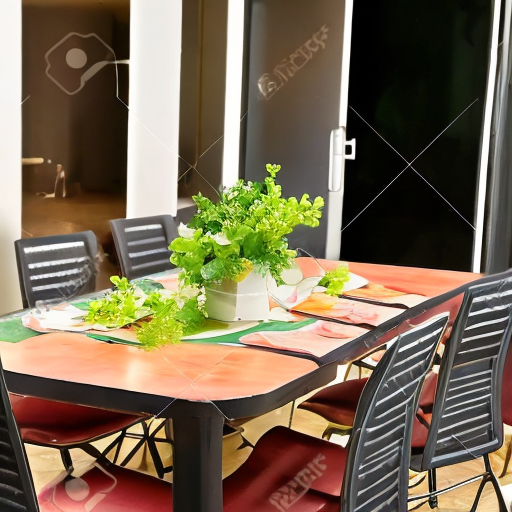

In [23]:
output_image[0]

In [23]:
global_heat_map.heat_maps.shape

torch.Size([4096, 64, 64])

In [ ]:
# for i in range(global_heat_map.heat_maps.shape[0]):
#   plt.imshow(global_heat_map.heat_maps[i].cpu().numpy())
#   plt.show()

### Google Drive

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
%cd /content/drive/MyDrive/AIISC-Internship/text-based-object-discovery/Image-Attention

/content/drive/MyDrive/AIISC-Internship/text-based-object-discovery/Image-Attention


In [27]:
# np.save('1.npy', global_heat_map.heat_maps.cpu().numpy())

In [28]:
# output_image[0].save('1.png')

### Visualize Image Attentions

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

In [4]:
os.listdir()

['0.npy', '0.png', '1.npy', '1.png']

In [5]:
attn_heatmaps = np.load('1.npy')

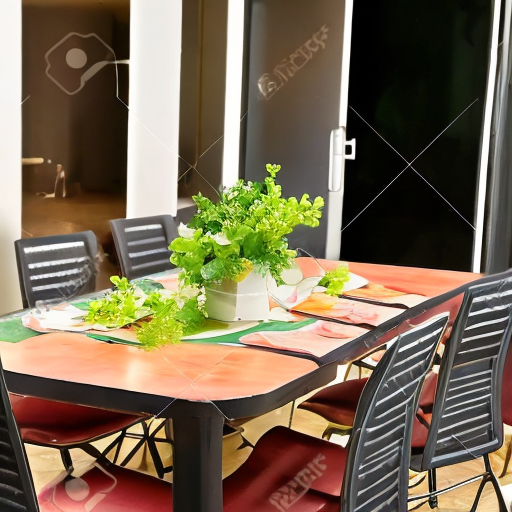

In [6]:
img = Image.open('1.png')
img

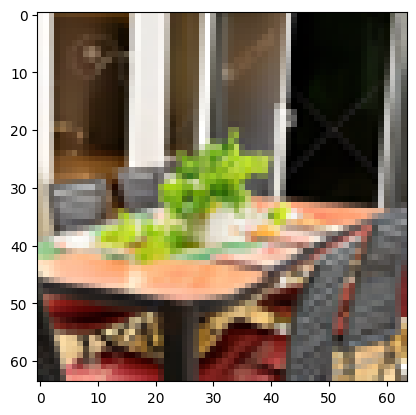

In [30]:
plt.imshow(np.asarray(img.resize((64, 64))))

In [12]:
attn_heatmaps.shape

(4096, 64, 64)

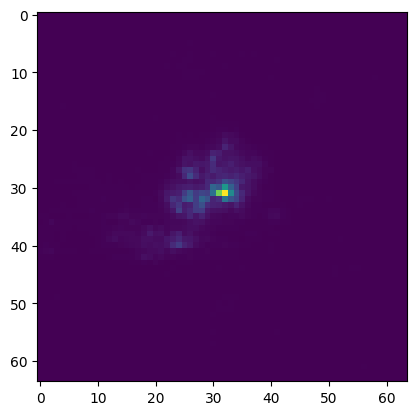

In [7]:
plt.imshow(attn_heatmaps[2016])

In [8]:
import torch
import torch.nn.functional as F

In [9]:
attn_heatmaps = torch.tensor(attn_heatmaps)

In [10]:
attn_heatmaps.shape

torch.Size([4096, 64, 64])

In [23]:
attn_im = attn_heatmaps.unsqueeze(1)
attn_im = F.interpolate(attn_im.float().detach(), size=(img.size[0], img.size[1]), mode='bicubic')
attn_im = attn_im[:,0]

In [27]:
attn_im.shape

torch.Size([4096, 512, 512])

In [36]:
def bbox_to_pix_ids(x1: int, y1: int, x2: int, y2: int, attn_im, img_height = 512, img_width = 512):
  pix_ids = [x for y in range(y1, y2+1) for x in range((img_height * y) + x1, (img_height * y) + x2 + 1) if x < (img_height * img_width)]
  return attn_im[pix_ids]

In [31]:
aa = bbox_to_pix_ids(10, 20, 43, 43, attn_heatmaps, 64, 64)

In [32]:
aa.shape

torch.Size([816, 64, 64])

In [33]:
aa = aa.mean(0)

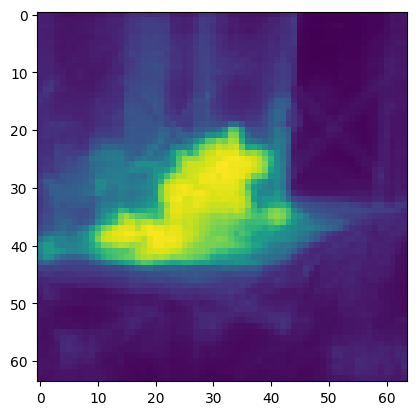

In [34]:
plt.imshow(aa)

In [37]:
aa = bbox_to_pix_ids(50, 40, 64, 64, attn_heatmaps, 64, 64)

In [38]:
aa.shape

torch.Size([359, 64, 64])

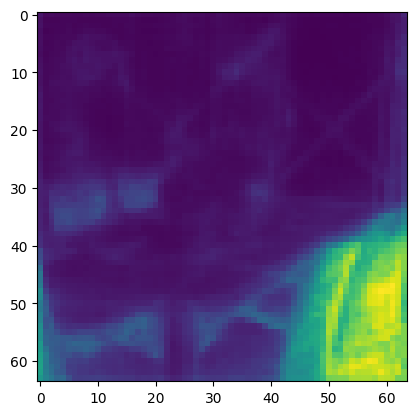

In [39]:
plt.imshow(aa.mean(0))

In [43]:
attn_heatmaps = np.load('0.npy')

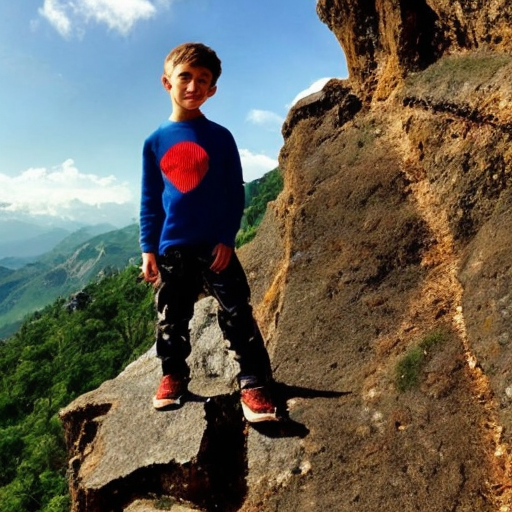

In [44]:
img = Image.open('0.png')
img

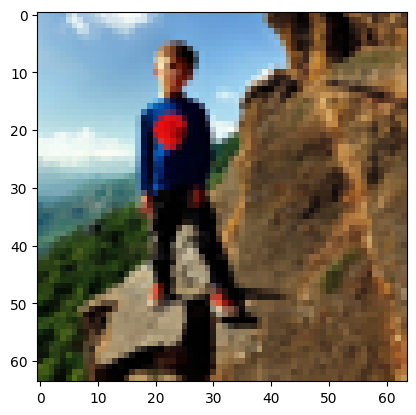

In [45]:
plt.imshow(np.asarray(img.resize((64, 64))))

In [46]:
attn_heatmaps.shape

(4096, 64, 64)

In [48]:
import torch
import torch.nn.functional as F

In [49]:
attn_heatmaps = torch.tensor(attn_heatmaps)

In [50]:
attn_heatmaps.shape

torch.Size([4096, 64, 64])

In [ ]:
attn_im = attn_heatmaps.unsqueeze(1)
attn_im = F.interpolate(attn_im.float().detach(), size=(img.size[0], img.size[1]), mode='bicubic')
attn_im = attn_im[:,0]

In [ ]:
attn_im.shape

torch.Size([4096, 512, 512])

In [51]:
def bbox_to_pix_ids(x1: int, y1: int, x2: int, y2: int, attn_im, img_height = 512, img_width = 512):
  pix_ids = [x for y in range(y1, y2+1) for x in range((img_height * y) + x1, (img_height * y) + x2 + 1) if x < (img_height * img_width)]
  return attn_im[pix_ids]

In [52]:
aa = bbox_to_pix_ids(30, 0, 64, 64, attn_heatmaps, 64, 64)

In [53]:
aa.shape

torch.Size([2239, 64, 64])

In [54]:
aa = aa.mean(0)

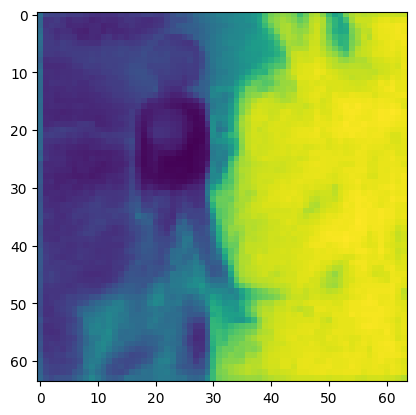

In [55]:
plt.imshow(aa)

In [59]:
aa = bbox_to_pix_ids(15, 4, 38, 55, attn_heatmaps, 64, 64)

In [60]:
aa.shape

torch.Size([1248, 64, 64])

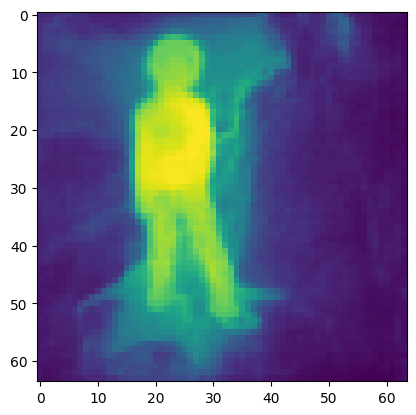

In [61]:
plt.imshow(aa.mean(0))